<a href="https://colab.research.google.com/github/marendtz/ModelNER/blob/master/XLMR_finetune_pan_and_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [1]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom')
except:
  print("no such folder")

no such folder


In [2]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [3]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Jun 16 11:20 ./
drwxr-xr-x 1 root root 4096 Jun 16 11:17 ../
drwxr-xr-x 4 root root 4096 Jun 14 18:26 .config/


'/content'

In [4]:
# clone github repo
!git clone https://{token}@github.com/marendtz/ModelNER.git

Cloning into 'ModelNER'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 78 (delta 43), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (78/78), 1.18 MiB | 1.39 MiB/s, done.


In [5]:
# check python version
!python --version

Python 3.10.12


In [6]:
# install dependencies
%pip install -r /content/ModelNER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5

In [7]:
# adjust pickle version used, since different version throws error with ray backend for hyperparameter optimization
!pip install pickle5==0.0.10
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 856.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.10-cp310-cp310-linux_x86_64.whl size=256409 sha256=ce812090fef24c6cdf9d888999de0fed15c78a5c025f6ab93d790a66cd1d0e57
  Stored in directory: /root/.cache/pip/wheels/bf/bd/b7/5878d60e6e87179a28ca3ae428fcb19c2983c6662786c3888b
Successfully built pickle5


In [8]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Get and Analyze dataset from Huggingface**

In [9]:
# login to HugginFace to enable upload of model
notebook_login()

In [20]:
# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...

ds = load_dataset("maren-hugg/sustainability_ner")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


**Prepare input data for following training of the model XLMRobertaForTokenClassification (with our config=labels, device, ...)**

In [11]:
# prepare dataset
ds_custom = ds
print("Example element in Custom Dataset:")
ds_custom_element = ds["train"][1]
for key, value in ds_custom_element.items():
    print(f"{key}: {value}")

Example element in Custom Dataset:
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]
tokens: ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']


In [12]:
# show info about tag feature --> we already defined the varibale tags earlier
# --> DatasetDict holds information about all features used (like infos on columns in dataframe)
print('----------features----------------')
print(ds_custom["train"].features)
print('----------feature ner_tags----------------')
print(ds_custom["train"].features["ner_tags"].feature)


----------features----------------
{'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
----------feature ner_tags----------------
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [13]:
# examples
print(ds_custom["train"][1])
print(ds_custom["train"][1]["tokens"])
print(ds_custom["train"][1]["ner_tags"])

{'ner_tags': [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0], 'tokens': ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']}
['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']
[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]


Count PER-Tag: 91
Count ORG-Tag: 1716
Count LOC-Tag: 629


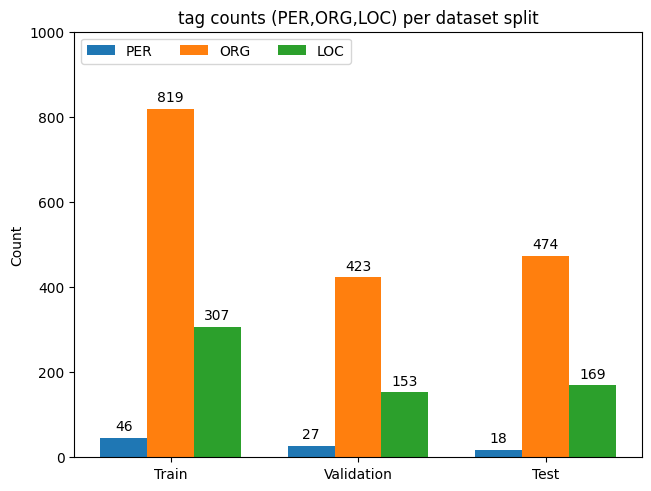

In [14]:
# getting info about tag-counts of labeled data
count_per = 0
count_org = 0
count_loc = 0
for sentence in ds_custom["train"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
train_count_per= count_per
train_count_org= count_org
train_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["validation"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
val_count_per= count_per
val_count_org= count_org
val_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["test"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
test_count_per= count_per
test_count_org= count_org
test_count_loc= count_loc


print(f"Count PER-Tag: {train_count_per+val_count_per+test_count_per}")
print(f"Count ORG-Tag: {train_count_org+val_count_org+test_count_org}")
print(f"Count LOC-Tag: {train_count_loc+val_count_loc+test_count_loc}")

splits = ("Train", "Validation", "Test")
split_values = {
    'PER': (train_count_per, val_count_per, test_count_per),
    'ORG': (train_count_org, val_count_org, test_count_org),
    'LOC': (train_count_loc, val_count_loc, test_count_loc),
}

x = np.arange(len(splits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in split_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('tag counts (PER,ORG,LOC) per dataset split')
ax.set_xticks(x + width, splits)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1000)

plt.show()

**Set tokenizer**

In [21]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [22]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_ds_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



In [23]:
# encode dataset
ds_custom_encoded = encode_ds_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["train"][1])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Encoded example:
{'input_ids': [0, 81201, 24639, 83, 2843, 10, 32786, 111, 70, 143889, 7, 242, 125413, 1832, 297, 25617, 185790, 136, 83, 127298, 2831, 111, 70, 2265, 165410, 36457, 538, 41361, 71, 17721, 70, 12924, 136, 39108, 289, 53099, 136, 70, 79883, 94492, 52350, 69941, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 4, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 3, -100, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, 4, 0, 0, 0, -100, -100]}


**Define performance measures**

In [24]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred)
          #"classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2) # throws error within parameter optimization
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [25]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [26]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
num_epochs = 3
batch_size = 24
learning_rate = 5e-5
weight_decay= 0.01

logging_steps = len(ds_custom_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-custom"
training_args = TrainingArguments(output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps", eval_steps=batch_size, # Number of update steps between two evaluations if evaluation_strategy="steps".
                                  save_strategy="steps", save_steps=1e6,
                                  learning_rate=learning_rate, #  The initial learning rate for AdamW optimizer.
                                  weight_decay=weight_decay, # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
                                  disable_tqdm=False,
                                  logging_strategy="steps", logging_steps=batch_size,  # Number of update steps between two logs if logging_strategy="steps".
                                  push_to_hub=True)

In [27]:
# this model needs to be created at huggingface:
f"{xlmr_model_name}-custom"

'maren-hugg/xlm-roberta-base-finetuned-panx-en-custom'

In [28]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [29]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [30]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_custom_encoded["train"],
                  eval_dataset=ds_custom_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/1.03G [00:00<?, ?B/s]

Download file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5:  43%|####2 …

Download file tokenizer.json:   0%|          | 8.00k/16.3M [00:00<?, ?B/s]

Download file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6: 100%|######…

Download file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7: 100%|######…

Download file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4: 100%|######…

Download file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0: 100%|######…

Download file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3: 100%|######…

Download file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1: 100%|######…

Clean file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0:  10%|#        …

Clean file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7:  12%|#1       …

Clean file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6:   7%|7        …

Clean file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4:  12%|#1       …

Clean file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5:   5%|5        …

Clean file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1:  17%|#6       …

Clean file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3:  17%|#6       …

Download file runs/Jun16_07-03-14_5da9701ecdaf/events.out.tfevents.1686899559.5da9701ecdaf.17298.0: 100%|#####…

Clean file runs/Jun16_07-03-14_5da9701ecdaf/events.out.tfevents.1686899559.5da9701ecdaf.17298.0:  13%|#2      …

Download file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837823.cd3a4fb4af4b.30403.0: 100%|#####…

Clean file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837823.cd3a4fb4af4b.30403.0:  14%|#3      …

Download file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837998.cd3a4fb4af4b.30403.1: 100%|#####…

Clean file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837998.cd3a4fb4af4b.30403.1:  14%|#3      …

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [31]:
# optimize hyperparameters
# default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune

tune_config = {
        "per_device_train_batch_size": tune.choice([16, 32, 64]),
        "per_device_eval_batch_size": tune.choice([16, 32, 64]),
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "learning_rate":  tune.uniform(1e-5, 5e-5),
        "weight_decay":tune.uniform(0.0, 0.3)
    }

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    n_trials=20, # number of trials
    hp_space=lambda _: tune_config,
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    # Choose among schedulers:
    # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
    scheduler=ASHAScheduler(metric="objective", mode="max")
)

2023-06-16 11:56:39,943	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-16 11:56:44,003	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/latest/tune/api/trainable.html

  warnings.warn(


== Status ==
Current time: 2023-06-16 11:56:44 (running for 00:00:00.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_54dfdd6b | PENDING  | 

(pid=10823) 2023-06-16 11:56:48.983421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:56:49 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_54dfdd6b | PENDING

(_objective pid=10823) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=10823)   warnings.warn(
 34%|███▍      | 22/64 [00:03<00:05,  8.19it/s]


== Status ==
Current time: 2023-06-16 11:56:59 (running for 00:00:15.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |                   |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------------------+-----------------+--------------------+------------------------+---------------

  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=10823) 
 50%|█████     | 4/8 [00:00<00:00, 36.82it/s]


(_objective pid=10823) {'loss': 0.1277, 'learning_rate': 1.680412847534473e-05, 'epoch': 1.5}
Result for _objective_54dfdd6b:
  date: 2023-06-16_11-57-00
  done: false
  epoch: 1.5
  eval_accuracy: 0.8383999999999999
  eval_f1: 0.8383999999999999
  eval_loss: 0.11677412688732147
  eval_precision: 0.8098918083462133
  eval_recall: 0.8689883913764511
  eval_runtime: 0.3758
  eval_samples_per_second: 665.191
  eval_steps_per_second: 21.286
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3556801997226646
  pid: 10823
  time_since_restore: 10.127326965332031
  time_this_iter_s: 10.127326965332031
  time_total_s: 10.127326965332031
  timestamp: 1686916620
  training_iteration: 1
  trial_id: 54dfdd6b
  
(_objective pid=10823) {'eval_loss': 0.11677412688732147, 'eval_f1': 0.8383999999999999, 'eval_precision': 0.8098918083462133, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8383999999999999, 'eval_runtime': 0.3758, 'eval_samples_per_second':

(_objective pid=10823) 
                                               
100%|██████████| 8/8 [00:00<00:00, 31.88it/s]
                                             
  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=10823) {'loss': 0.0584, 'learning_rate': 6.7216513901378915e-06, 'epoch': 3.0}


(_objective pid=10823) 
 50%|█████     | 4/8 [00:00<00:00, 36.79it/s]
(_objective pid=10823) 
100%|██████████| 8/8 [00:00<00:00, 31.89it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 31.89it/s]
                                             
 77%|███████▋  | 49/64 [00:07<00:03,  4.96it/s]


(_objective pid=10823) {'eval_loss': 0.10319644957780838, 'eval_f1': 0.8629359286293592, 'eval_precision': 0.8444444444444444, 'eval_recall': 0.8822553897180763, 'eval_accuracy': 0.8629359286293592, 'eval_runtime': 0.3694, 'eval_samples_per_second': 676.838, 'eval_steps_per_second': 21.659, 'epoch': 3.0}


 86%|████████▌ | 55/64 [00:08<00:01,  7.31it/s]


== Status ==
Current time: 2023-06-16 11:57:04 (running for 00:00:20.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3556801997226646
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |          |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+----------+-------------------+-----------------+-----

100%|██████████| 64/64 [00:09<00:00,  6.87it/s]


(_objective pid=10823) {'train_runtime': 9.3204, 'train_samples_per_second': 214.582, 'train_steps_per_second': 6.867, 'train_loss': 0.08023025188595057, 'epoch': 4.0}
Result for _objective_54dfdd6b:
  date: 2023-06-16_11-57-03
  done: true
  epoch: 3.0
  eval_accuracy: 0.8629359286293592
  eval_f1: 0.8629359286293592
  eval_loss: 0.10319644957780838
  eval_precision: 0.8444444444444444
  eval_recall: 0.8822553897180763
  eval_runtime: 0.3694
  eval_samples_per_second: 676.838
  eval_steps_per_second: 21.659
  experiment_tag: 1_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=32,per_device_train_batch_size=32,weight_decay=0.2761
  hostname: cd0b2d7ebdde
  iterations_since_restore: 2
  node_ip: 172.28.0.12
  objective: 3.452571691421239
  pid: 10823
  time_since_restore: 13.586235046386719
  time_this_iter_s: 3.4589080810546875
  time_total_s: 13.586235046386719
  timestamp: 1686916623
  training_iteration: 2
  trial_id: 54dfdd6b
  
Trial _objective_54dfdd6b completed.

(pid=11065) 2023-06-16 11:57:10.602716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:57:14 (running for 00:00:30.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3556801997226646
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

(_objective pid=11065) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11065)   warnings.warn(
 38%|███▊      | 6/16 [00:01<00:02,  4.10it/s]


== Status ==
Current time: 2023-06-16 11:57:19 (running for 00:00:35.37)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3556801997226646
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

 38%|███▊      | 6/16 [00:00<00:00, 58.12it/s]


(_objective pid=11065) {'train_runtime': 4.0302, 'train_samples_per_second': 248.126, 'train_steps_per_second': 3.97, 'train_loss': 0.16806110739707947, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:00<00:00, 53.60it/s]


Result for _objective_acf7f431:
  date: 2023-06-16_11-57-22
  done: true
  epoch: 2.0
  eval_accuracy: 0.788309636650869
  eval_f1: 0.788309636650869
  eval_loss: 0.1447729468345642
  eval_precision: 0.7526395173453997
  eval_recall: 0.8275290215588723
  eval_runtime: 0.3965
  eval_samples_per_second: 630.443
  eval_steps_per_second: 40.348
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.1567878122060096
  pid: 11065
  time_since_restore: 10.678837776184082
  time_this_iter_s: 10.678837776184082
  time_total_s: 10.678837776184082
  timestamp: 1686916642
  training_iteration: 1
  trial_id: acf7f431
  
Trial _objective_acf7f431 completed.


100%|██████████| 16/16 [00:00<00:00, 42.79it/s]


== Status ==
Current time: 2023-06-16 11:57:24 (running for 00:00:40.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.305957102843501
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 3/20 (1 PENDING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-------------

(pid=11217) 2023-06-16 11:57:27.580591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:57:29 (running for 00:00:45.50)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.305957102843501
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+--

(_objective pid=11217) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11217)   warnings.warn(
 33%|███▎      | 21/64 [00:01<00:03, 13.43it/s]


(_objective pid=11217) {'loss': 0.162, 'learning_rate': 8.012636477602746e-06, 'epoch': 0.75}


 38%|███▊      | 24/64 [00:01<00:03, 13.20it/s]
(_objective pid=11217) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=11217) 
 38%|███▊      | 6/16 [00:00<00:00, 59.38it/s]
(_objective pid=11217) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.22it/s]


Result for _objective_643a3ad5:
  date: 2023-06-16_11-57-37
  done: true
  epoch: 0.75
  eval_accuracy: 0.80253766851705
  eval_f1: 0.80253766851705
  eval_loss: 0.1280485987663269
  eval_precision: 0.7689969604863222
  eval_recall: 0.8391376451077943
  eval_runtime: 0.3959
  eval_samples_per_second: 631.451
  eval_steps_per_second: 40.413
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2132099426282164
  pid: 11217
  time_since_restore: 8.588821649551392
  time_this_iter_s: 8.588821649551392
  time_total_s: 8.588821649551392
  timestamp: 1686916657
  training_iteration: 1
  trial_id: 643a3ad5
  
Trial _objective_643a3ad5 completed.
(_objective pid=11217) {'eval_loss': 0.1280485987663269, 'eval_f1': 0.80253766851705, 'eval_precision': 0.7689969604863222, 'eval_recall': 0.8391376451077943, 'eval_accuracy': 0.80253766851705, 'eval_runtime': 0.3959, 'eval_samples_per_second': 631.451, 'eval_steps_per_second': 40.413, 'epoch': 0.75}


                                               
 38%|███▊      | 24/64 [00:02<00:03, 10.18it/s]


== Status ==
Current time: 2023-06-16 11:57:39 (running for 00:00:55.60)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.2844450711754405
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 4/20 (1 PENDING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+------------

(pid=11356) 2023-06-16 11:57:42.615991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:57:44 (running for 00:01:00.64)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.2844450711754405
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

(_objective pid=11356) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11356)   warnings.warn(
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=11356) 
 50%|█████     | 4/8 [00:00<00:00, 36.67it/s]


(_objective pid=11356) {'loss': 0.1326, 'learning_rate': 2.617291973526556e-05, 'epoch': 0.75}


(_objective pid=11356) 
100%|██████████| 8/8 [00:00<00:00, 31.67it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 31.67it/s]
                                             


Result for _objective_70f16e64:
  date: 2023-06-16_11-57-52
  done: false
  epoch: 0.75
  eval_accuracy: 0.8421052631578947
  eval_f1: 0.8421052631578947
  eval_loss: 0.11662121117115021
  eval_precision: 0.8110599078341014
  eval_recall: 0.8756218905472637
  eval_runtime: 0.3716
  eval_samples_per_second: 672.715
  eval_steps_per_second: 21.527
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3708923246971545
  pid: 11356
  time_since_restore: 8.590605020523071
  time_this_iter_s: 8.590605020523071
  time_total_s: 8.590605020523071
  timestamp: 1686916672
  training_iteration: 1
  trial_id: 70f16e64
  
(_objective pid=11356) {'eval_loss': 0.11662121117115021, 'eval_f1': 0.8421052631578947, 'eval_precision': 0.8110599078341014, 'eval_recall': 0.8756218905472637, 'eval_accuracy': 0.8421052631578947, 'eval_runtime': 0.3716, 'eval_samples_per_second': 672.715, 'eval_steps_per_second': 21.527, 'epoch': 0.75}


 50%|█████     | 48/96 [00:04<00:03, 13.33it/s]


(_objective pid=11356) {'loss': 0.0726, 'learning_rate': 1.744861315684371e-05, 'epoch': 1.5}


(_objective pid=11356) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=11356) 
 50%|█████     | 4/8 [00:00<00:00, 37.04it/s]
(_objective pid=11356) 
100%|██████████| 8/8 [00:00<00:00, 31.92it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 31.92it/s]
                                             


(_objective pid=11356) {'eval_loss': 0.0984741821885109, 'eval_f1': 0.8608414239482202, 'eval_precision': 0.8404423380726699, 'eval_recall': 0.8822553897180763, 'eval_accuracy': 0.8608414239482202, 'eval_runtime': 0.3685, 'eval_samples_per_second': 678.433, 'eval_steps_per_second': 21.71, 'epoch': 1.5}


 56%|█████▋    | 54/96 [00:04<00:04,  9.96it/s]


== Status ==
Current time: 2023-06-16 11:57:54 (running for 00:01:10.71)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.359483230966287
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+--

  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=11356) 
 50%|█████     | 4/8 [00:00<00:00, 37.41it/s]


(_objective pid=11356) {'loss': 0.0547, 'learning_rate': 8.724306578421854e-06, 'epoch': 2.25}


(_objective pid=11356) 
100%|██████████| 8/8 [00:00<00:00, 32.12it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 32.12it/s]
                                             


(_objective pid=11356) {'eval_loss': 0.09798742830753326, 'eval_f1': 0.8647342995169083, 'eval_precision': 0.8403755868544601, 'eval_recall': 0.8905472636815921, 'eval_accuracy': 0.8647342995169083, 'eval_runtime': 0.3657, 'eval_samples_per_second': 683.672, 'eval_steps_per_second': 21.877, 'epoch': 2.25}


  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=11356) {'loss': 0.043, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=11356) 
 50%|█████     | 4/8 [00:00<00:00, 37.39it/s]
(_objective pid=11356) 
100%|██████████| 8/8 [00:00<00:00, 32.22it/s]
                                               
100%|██████████| 96/96 [00:08<00:00, 10.78it/s]


Result for _objective_70f16e64:
  date: 2023-06-16_11-57-58
  done: false
  epoch: 3.0
  eval_accuracy: 0.868229587712207
  eval_f1: 0.868229587712207
  eval_loss: 0.09690428525209427
  eval_precision: 0.8470031545741324
  eval_recall: 0.8905472636815921
  eval_runtime: 0.3657
  eval_samples_per_second: 683.55
  eval_steps_per_second: 21.874
  hostname: cd0b2d7ebdde
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.4740095936801385
  pid: 11356
  time_since_restore: 15.138965368270874
  time_this_iter_s: 2.1442928314208984
  time_total_s: 15.138965368270874
  timestamp: 1686916678
  training_iteration: 4
  trial_id: 70f16e64
  
(_objective pid=11356) {'eval_loss': 0.09690428525209427, 'eval_f1': 0.868229587712207, 'eval_precision': 0.8470031545741324, 'eval_recall': 0.8905472636815921, 'eval_accuracy': 0.868229587712207, 'eval_runtime': 0.3657, 'eval_samples_per_second': 683.55, 'eval_steps_per_second': 21.874, 'epoch': 3.0}
(_objective pid=11356) {'train_runtime': 8.

(pid=11576) 2023-06-16 11:58:03.633017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:58:04 (running for 00:01:20.87)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4740095936801385 | Iter 1.000: 3.359483230966287
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

(_objective pid=11576) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11576)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=11576) {'loss': 0.1278, 'learning_rate': 3.167774886087884e-05, 'epoch': 0.75}


(_objective pid=11576) 
 38%|███▊      | 6/16 [00:00<00:00, 59.21it/s]
(_objective pid=11576) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.12it/s]


Result for _objective_42e498b1:
  date: 2023-06-16_11-58-13
  done: false
  epoch: 0.75
  eval_accuracy: 0.8486312399355879
  eval_f1: 0.8486312399355879
  eval_loss: 0.10569430887699127
  eval_precision: 0.8247261345852895
  eval_recall: 0.8739635157545605
  eval_runtime: 0.394
  eval_samples_per_second: 634.571
  eval_steps_per_second: 40.613
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.395952130211026
  pid: 11576
  time_since_restore: 8.670559644699097
  time_this_iter_s: 8.670559644699097
  time_total_s: 8.670559644699097
  timestamp: 1686916693
  training_iteration: 1
  trial_id: 42e498b1
  
(_objective pid=11576) {'eval_loss': 0.10569430887699127, 'eval_f1': 0.8486312399355879, 'eval_precision': 0.8247261345852895, 'eval_recall': 0.8739635157545605, 'eval_accuracy': 0.8486312399355879, 'eval_runtime': 0.394, 'eval_samples_per_second': 634.571, 'eval_steps_per_second': 40.613, 'epoch': 0.75}


                                                
100%|██████████| 16/16 [00:00<00:00, 54.12it/s]
                                               
 36%|███▌      | 46/128 [00:04<00:06, 13.10it/s]


== Status ==
Current time: 2023-06-16 11:58:15 (running for 00:01:30.94)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4740095936801385 | Iter 1.000: 3.3708923246971545
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=11576) 
 38%|███▊      | 6/16 [00:00<00:00, 59.45it/s]
(_objective pid=11576) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.28it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 54.28it/s]
                                               


(_objective pid=11576) {'eval_loss': 0.1019999235868454, 'eval_f1': 0.861088545897644, 'eval_precision': 0.8439490445859873, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.861088545897644, 'eval_runtime': 0.3945, 'eval_samples_per_second': 633.764, 'eval_steps_per_second': 40.561, 'epoch': 1.5}


 56%|█████▋    | 72/128 [00:06<00:04, 12.64it/s]


(_objective pid=11576) {'loss': 0.0521, 'learning_rate': 1.7057249386627068e-05, 'epoch': 2.25}


(_objective pid=11576) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=11576) 
 38%|███▊      | 6/16 [00:00<00:00, 59.49it/s]
(_objective pid=11576) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.01it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 54.01it/s]
                                               


(_objective pid=11576) {'eval_loss': 0.09815487265586853, 'eval_f1': 0.8702659145850121, 'eval_precision': 0.8463949843260188, 'eval_recall': 0.8955223880597015, 'eval_accuracy': 0.8702659145850121, 'eval_runtime': 0.3934, 'eval_samples_per_second': 635.533, 'eval_steps_per_second': 40.674, 'epoch': 2.25}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=11576) 
 38%|███▊      | 6/16 [00:00<00:00, 59.25it/s]


(_objective pid=11576) {'loss': 0.0397, 'learning_rate': 9.746999649501182e-06, 'epoch': 3.0}


(_objective pid=11576) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.35it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 54.35it/s]
                                               


Result for _objective_42e498b1:
  date: 2023-06-16_11-58-19
  done: false
  epoch: 3.0
  eval_accuracy: 0.8730800323362976
  eval_f1: 0.8730800323362976
  eval_loss: 0.09843031316995621
  eval_precision: 0.8517350157728707
  eval_recall: 0.8955223880597015
  eval_runtime: 0.3924
  eval_samples_per_second: 637.077
  eval_steps_per_second: 40.773
  hostname: cd0b2d7ebdde
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.493417468505167
  pid: 11576
  time_since_restore: 15.309832334518433
  time_this_iter_s: 2.188796281814575
  time_total_s: 15.309832334518433
  timestamp: 1686916699
  training_iteration: 4
  trial_id: 42e498b1
  
(_objective pid=11576) {'eval_loss': 0.09843031316995621, 'eval_f1': 0.8730800323362976, 'eval_precision': 0.8517350157728707, 'eval_recall': 0.8955223880597015, 'eval_accuracy': 0.8730800323362976, 'eval_runtime': 0.3924, 'eval_samples_per_second': 637.077, 'eval_steps_per_second': 40.773, 'epoch': 3.0}
== Status ==
Current time: 2023-06-16 1

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=11576) {'loss': 0.0248, 'learning_rate': 2.4367499123752954e-06, 'epoch': 3.75}


(_objective pid=11576) 
 38%|███▊      | 6/16 [00:00<00:00, 59.27it/s]
(_objective pid=11576) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.12it/s]
                                                 
100%|██████████| 16/16 [00:00<00:00, 54.12it/s]
                                               


(_objective pid=11576) {'eval_loss': 0.0999220609664917, 'eval_f1': 0.8784440842787682, 'eval_precision': 0.8589540412044374, 'eval_recall': 0.8988391376451078, 'eval_accuracy': 0.8784440842787682, 'eval_runtime': 0.3935, 'eval_samples_per_second': 635.312, 'eval_steps_per_second': 40.66, 'epoch': 3.75}


100%|██████████| 128/128 [00:11<00:00, 10.82it/s]


(_objective pid=11576) {'train_runtime': 11.8323, 'train_samples_per_second': 169.029, 'train_steps_per_second': 10.818, 'train_loss': 0.060014406219124794, 'epoch': 4.0}
Result for _objective_42e498b1:
  date: 2023-06-16_11-58-22
  done: true
  epoch: 3.75
  eval_accuracy: 0.8784440842787682
  eval_f1: 0.8784440842787682
  eval_loss: 0.0999220609664917
  eval_precision: 0.8589540412044374
  eval_recall: 0.8988391376451078
  eval_runtime: 0.3935
  eval_samples_per_second: 635.312
  eval_steps_per_second: 40.66
  experiment_tag: 5_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_decay=0.0480
  hostname: cd0b2d7ebdde
  iterations_since_restore: 5
  node_ip: 172.28.0.12
  objective: 3.5146813474070813
  pid: 11576
  time_since_restore: 17.525291204452515
  time_this_iter_s: 2.215458869934082
  time_total_s: 17.525291204452515
  timestamp: 1686916702
  training_iteration: 5
  trial_id: 42e498b1
  
Trial _objective_42e498b1 complete

(pid=11835) 2023-06-16 11:58:28.653569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:58:30 (running for 00:01:46.06)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.3708923246971545
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------

(_objective pid=11835) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11835)   warnings.warn(
 38%|███▊      | 24/64 [00:01<00:02, 13.40it/s]


(_objective pid=11835) {'loss': 0.1381, 'learning_rate': 1.7437078680140957e-05, 'epoch': 0.75}


(_objective pid=11835) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=11835) 
 38%|███▊      | 6/16 [00:00<00:00, 57.97it/s]
(_objective pid=11835) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.53it/s]
                                               
 38%|███▊      | 24/64 [00:02<00:03, 10.11it/s]


Result for _objective_7b20a8c2:
  date: 2023-06-16_11-58-38
  done: true
  epoch: 0.75
  eval_accuracy: 0.8383999999999999
  eval_f1: 0.8383999999999999
  eval_loss: 0.11030517518520355
  eval_precision: 0.8098918083462133
  eval_recall: 0.8689883913764511
  eval_runtime: 0.3984
  eval_samples_per_second: 627.518
  eval_steps_per_second: 40.161
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3556801997226646
  pid: 11835
  time_since_restore: 8.623755931854248
  time_this_iter_s: 8.623755931854248
  time_total_s: 8.623755931854248
  timestamp: 1686916718
  training_iteration: 1
  trial_id: 7b20a8c2
  
Trial _objective_7b20a8c2 completed.
(_objective pid=11835) {'eval_loss': 0.11030517518520355, 'eval_f1': 0.8383999999999999, 'eval_precision': 0.8098918083462133, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8383999999999999, 'eval_runtime': 0.3984, 'eval_samples_per_second': 627.518, 'eval_steps_per_second': 40.161, 'epoch': 0.75}
==

(pid=11975) 2023-06-16 11:58:43.594212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:58:45 (running for 00:02:01.20)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.367089293453532
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------

(_objective pid=11975) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=11975)   warnings.warn(
  0%|          | 0/64 [00:00<?, ?it/s]
(_objective pid=11975) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 38%|███▊      | 24/64 [00:03<00:04,  8.13it/s]


(_objective pid=11975) {'loss': 0.1303, 'learning_rate': 2.715829377058839e-05, 'epoch': 1.5}


(_objective pid=11975) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=11975) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.90it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.90it/s]
                                             


Result for _objective_d4c0bb85:
  date: 2023-06-16_11-58-54
  done: false
  epoch: 1.5
  eval_accuracy: 0.8552950687146321
  eval_f1: 0.8552950687146321
  eval_loss: 0.10795333981513977
  eval_precision: 0.8343848580441641
  eval_recall: 0.8772802653399668
  eval_runtime: 0.3571
  eval_samples_per_second: 700.158
  eval_steps_per_second: 11.203
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.422255260813395
  pid: 11975
  time_since_restore: 9.832195281982422
  time_this_iter_s: 9.832195281982422
  time_total_s: 9.832195281982422
  timestamp: 1686916734
  training_iteration: 1
  trial_id: d4c0bb85
  
(_objective pid=11975) {'eval_loss': 0.10795333981513977, 'eval_f1': 0.8552950687146321, 'eval_precision': 0.8343848580441641, 'eval_recall': 0.8772802653399668, 'eval_accuracy': 0.8552950687146321, 'eval_runtime': 0.3571, 'eval_samples_per_second': 700.158, 'eval_steps_per_second': 11.203, 'epoch': 1.5}


 44%|████▍     | 28/64 [00:04<00:06,  5.90it/s]


== Status ==
Current time: 2023-06-16 11:58:55 (running for 00:02:11.23)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.38342222745409
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------

 75%|███████▌  | 48/64 [00:06<00:02,  7.96it/s]


(_objective pid=11975) {'loss': 0.0513, 'learning_rate': 1.0863317508235357e-05, 'epoch': 3.0}


(_objective pid=11975) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=11975) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.87it/s]


(_objective pid=11975) {'eval_loss': 0.09304799139499664, 'eval_f1': 0.8768472906403941, 'eval_precision': 0.8682926829268293, 'eval_recall': 0.8855721393034826, 'eval_accuracy': 0.8768472906403941, 'eval_runtime': 0.3574, 'eval_samples_per_second': 699.518, 'eval_steps_per_second': 11.192, 'epoch': 3.0}


                                               
100%|██████████| 4/4 [00:00<00:00, 20.87it/s]
                                             
100%|██████████| 64/64 [00:09<00:00,  7.08it/s]


(_objective pid=11975) {'train_runtime': 9.0423, 'train_samples_per_second': 221.184, 'train_steps_per_second': 7.078, 'train_loss': 0.07602601684629917, 'epoch': 4.0}
Result for _objective_d4c0bb85:
  date: 2023-06-16_11-58-58
  done: true
  epoch: 3.0
  eval_accuracy: 0.8768472906403941
  eval_f1: 0.8768472906403941
  eval_loss: 0.09304799139499664
  eval_precision: 0.8682926829268293
  eval_recall: 0.8855721393034826
  eval_runtime: 0.3574
  eval_samples_per_second: 699.518
  eval_steps_per_second: 11.192
  experiment_tag: 7_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight_decay=0.2061
  hostname: cd0b2d7ebdde
  iterations_since_restore: 2
  node_ip: 172.28.0.12
  objective: 3.5075594035110997
  pid: 11975
  time_since_restore: 13.270652055740356
  time_this_iter_s: 3.4384567737579346
  time_total_s: 13.270652055740356
  timestamp: 1686916738
  training_iteration: 2
  trial_id: d4c0bb85
  
Trial _objective_d4c0bb85 completed

(pid=12204) 2023-06-16 11:59:05.642532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:59:10 (running for 00:02:26.29)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.38342222745409
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------

(_objective pid=12204) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12204)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=12204) 
 38%|███▊      | 6/16 [00:00<00:00, 59.54it/s]


(_objective pid=12204) {'loss': 0.1234, 'learning_rate': 3.2938758949526863e-05, 'epoch': 0.75}


(_objective pid=12204) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.53it/s]


Result for _objective_0ae7206a:
  date: 2023-06-16_11-59-15
  done: false
  epoch: 0.75
  eval_accuracy: 0.8477905073649753
  eval_f1: 0.8477905073649753
  eval_loss: 0.09958718717098236
  eval_precision: 0.8368336025848142
  eval_recall: 0.8590381426202321
  eval_runtime: 0.3925
  eval_samples_per_second: 637.019
  eval_steps_per_second: 40.769
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.391452759934997
  pid: 12204
  time_since_restore: 8.631963729858398
  time_this_iter_s: 8.631963729858398
  time_total_s: 8.631963729858398
  timestamp: 1686916755
  training_iteration: 1
  trial_id: 0ae7206a
  
(_objective pid=12204) {'eval_loss': 0.09958718717098236, 'eval_f1': 0.8477905073649753, 'eval_precision': 0.8368336025848142, 'eval_recall': 0.8590381426202321, 'eval_accuracy': 0.8477905073649753, 'eval_runtime': 0.3925, 'eval_samples_per_second': 637.019, 'eval_steps_per_second': 40.769, 'epoch': 0.75}


                                               
100%|██████████| 16/16 [00:00<00:00, 54.53it/s]
                                               
 27%|██▋       | 26/96 [00:02<00:09,  7.38it/s]


== Status ==
Current time: 2023-06-16 11:59:15 (running for 00:02:31.31)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.392577602504004
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------

 50%|█████     | 48/96 [00:04<00:03, 13.32it/s]


(_objective pid=12204) {'loss': 0.0696, 'learning_rate': 2.1959172633017908e-05, 'epoch': 1.5}


(_objective pid=12204) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=12204) 
 38%|███▊      | 6/16 [00:00<00:00, 59.39it/s]
(_objective pid=12204) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.64it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 53.64it/s]
                                               


(_objective pid=12204) {'eval_loss': 0.10817276686429977, 'eval_f1': 0.8527755430410298, 'eval_precision': 0.828125, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.8527755430410298, 'eval_runtime': 0.3962, 'eval_samples_per_second': 631.039, 'eval_steps_per_second': 40.387, 'epoch': 1.5}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=12204) 
 38%|███▊      | 6/16 [00:00<00:00, 59.50it/s]


(_objective pid=12204) {'loss': 0.0526, 'learning_rate': 1.0979586316508954e-05, 'epoch': 2.25}


(_objective pid=12204) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.34it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 54.34it/s]
                                               
 77%|███████▋  | 74/96 [00:06<00:03,  7.27it/s]


(_objective pid=12204) {'eval_loss': 0.09828248620033264, 'eval_f1': 0.8713826366559486, 'eval_precision': 0.8455538221528861, 'eval_recall': 0.8988391376451078, 'eval_accuracy': 0.8713826366559486, 'eval_runtime': 0.3923, 'eval_samples_per_second': 637.336, 'eval_steps_per_second': 40.79, 'epoch': 2.25}


 85%|████████▌ | 82/96 [00:07<00:01, 10.79it/s]


== Status ==
Current time: 2023-06-16 11:59:20 (running for 00:02:36.36)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.48856549979891 | Iter 1.000: 3.392577602504004
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------

100%|██████████| 96/96 [00:08<00:00, 13.92it/s]
(_objective pid=12204) 
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=12204) {'loss': 0.0421, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=12204) 
 38%|███▊      | 6/16 [00:00<00:00, 59.30it/s]
(_objective pid=12204) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.98it/s]


Result for _objective_0ae7206a:
  date: 2023-06-16_11-59-21
  done: false
  epoch: 3.0
  eval_accuracy: 0.87987012987013
  eval_f1: 0.87987012987013
  eval_loss: 0.09586085379123688
  eval_precision: 0.8616852146263911
  eval_recall: 0.8988391376451078
  eval_runtime: 0.3943
  eval_samples_per_second: 634.008
  eval_steps_per_second: 40.576
  hostname: cd0b2d7ebdde
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.520264612011759
  pid: 12204
  time_since_restore: 15.275408029556274
  time_this_iter_s: 2.1910595893859863
  time_total_s: 15.275408029556274
  timestamp: 1686916761
  training_iteration: 4
  trial_id: 0ae7206a
  
(_objective pid=12204) {'eval_loss': 0.09586085379123688, 'eval_f1': 0.87987012987013, 'eval_precision': 0.8616852146263911, 'eval_recall': 0.8988391376451078, 'eval_accuracy': 0.87987012987013, 'eval_runtime': 0.3943, 'eval_samples_per_second': 634.008, 'eval_steps_per_second': 40.576, 'epoch': 3.0}
(_objective pid=12204) {'train_runtime': 9.012

                                               
100%|██████████| 96/96 [00:09<00:00, 10.65it/s]


Trial _objective_0ae7206a completed.
== Status ==
Current time: 2023-06-16 11:59:25 (running for 00:02:41.40)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.506841040258463 | Iter 1.000: 3.392577602504004
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 9/20 (1 PENDING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|------------------

(pid=12425) 2023-06-16 11:59:27.612648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:59:30 (running for 00:02:46.44)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.506841040258463 | Iter 1.000: 3.392577602504004
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

(_objective pid=12425) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12425)   warnings.warn(
  8%|▊         | 8/96 [00:00<00:07, 12.11it/s]


== Status ==
Current time: 2023-06-16 11:59:35 (running for 00:02:51.48)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.506841040258463 | Iter 1.000: 3.392577602504004
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

 23%|██▎       | 22/96 [00:01<00:05, 13.33it/s]


(_objective pid=12425) {'loss': 0.1214, 'learning_rate': 3.6246000017892004e-05, 'epoch': 0.75}


  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=12425) 
 50%|█████     | 4/8 [00:00<00:00, 37.30it/s]


Result for _objective_177f5ce4:
  date: 2023-06-16_11-59-37
  done: false
  epoch: 0.75
  eval_accuracy: 0.8555102040816327
  eval_f1: 0.8555102040816327
  eval_loss: 0.09727215766906738
  eval_precision: 0.842443729903537
  eval_recall: 0.8689883913764511
  eval_runtime: 0.366
  eval_samples_per_second: 683.135
  eval_steps_per_second: 21.86
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4224525294432535
  pid: 12425
  time_since_restore: 8.59325361251831
  time_this_iter_s: 8.59325361251831
  time_total_s: 8.59325361251831
  timestamp: 1686916777
  training_iteration: 1
  trial_id: 177f5ce4
  
(_objective pid=12425) {'eval_loss': 0.09727215766906738, 'eval_f1': 0.8555102040816327, 'eval_precision': 0.842443729903537, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8555102040816327, 'eval_runtime': 0.366, 'eval_samples_per_second': 683.135, 'eval_steps_per_second': 21.86, 'epoch': 0.75}


(_objective pid=12425) 
                                               
100%|██████████| 8/8 [00:00<00:00, 32.02it/s]
                                             
 50%|█████     | 48/96 [00:04<00:03, 13.28it/s]


(_objective pid=12425) {'loss': 0.0688, 'learning_rate': 2.4164000011928004e-05, 'epoch': 1.5}


(_objective pid=12425) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=12425) 
 50%|█████     | 4/8 [00:00<00:00, 37.01it/s]
(_objective pid=12425) 
100%|██████████| 8/8 [00:00<00:00, 31.96it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 31.96it/s]
                                             


(_objective pid=12425) {'eval_loss': 0.10398826003074646, 'eval_f1': 0.8656476267095737, 'eval_precision': 0.840625, 'eval_recall': 0.8922056384742952, 'eval_accuracy': 0.8656476267095737, 'eval_runtime': 0.3677, 'eval_samples_per_second': 679.846, 'eval_steps_per_second': 21.755, 'epoch': 1.5}


 69%|██████▉   | 66/96 [00:05<00:02, 12.51it/s]


== Status ==
Current time: 2023-06-16 11:59:40 (running for 00:02:56.52)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.506841040258463 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

 73%|███████▎  | 70/96 [00:06<00:01, 13.12it/s]


(_objective pid=12425) {'loss': 0.0495, 'learning_rate': 1.2082000005964002e-05, 'epoch': 2.25}


  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=12425) 
 50%|█████     | 4/8 [00:00<00:00, 37.19it/s]


(_objective pid=12425) {'eval_loss': 0.09906566143035889, 'eval_f1': 0.8785197103781175, 'eval_precision': 0.853125, 'eval_recall': 0.9054726368159204, 'eval_accuracy': 0.8785197103781175, 'eval_runtime': 0.367, 'eval_samples_per_second': 681.195, 'eval_steps_per_second': 21.798, 'epoch': 2.25}


(_objective pid=12425) 
                                               
100%|██████████| 8/8 [00:00<00:00, 31.86it/s]
                                             
  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=12425) {'loss': 0.0404, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=12425) 
 50%|█████     | 4/8 [00:00<00:00, 37.01it/s]


Result for _objective_177f5ce4:
  date: 2023-06-16_11-59-43
  done: false
  epoch: 3.0
  eval_accuracy: 0.8778501628664495
  eval_f1: 0.8778501628664495
  eval_loss: 0.09634144604206085
  eval_precision: 0.8624
  eval_recall: 0.8938640132669984
  eval_runtime: 0.367
  eval_samples_per_second: 681.208
  eval_steps_per_second: 21.799
  hostname: cd0b2d7ebdde
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.5119643389998974
  pid: 12425
  time_since_restore: 15.157334089279175
  time_this_iter_s: 2.157785177230835
  time_total_s: 15.157334089279175
  timestamp: 1686916783
  training_iteration: 4
  trial_id: 177f5ce4
  
(_objective pid=12425) {'eval_loss': 0.09634144604206085, 'eval_f1': 0.8778501628664495, 'eval_precision': 0.8624, 'eval_recall': 0.8938640132669984, 'eval_accuracy': 0.8778501628664495, 'eval_runtime': 0.367, 'eval_samples_per_second': 681.208, 'eval_steps_per_second': 21.799, 'epoch': 3.0}
(_objective pid=12425) {'train_runtime': 8.9043, 'train_samples_

(_objective pid=12425) 
                                               
100%|██████████| 96/96 [00:08<00:00, 10.78it/s]


Trial _objective_177f5ce4 completed.
== Status ==
Current time: 2023-06-16 11:59:45 (running for 00:03:01.54)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 10/20 (1 PENDING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|-----------------

(pid=12647) 2023-06-16 11:59:49.612522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 11:59:50 (running for 00:03:06.55)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

(_objective pid=12647) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12647)   warnings.warn(
 75%|███████▌  | 24/32 [00:03<00:00,  8.08it/s]
(_objective pid=12647) 
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=12647) {'loss': 0.1487, 'learning_rate': 4.009261364757339e-06, 'epoch': 1.5}


(_objective pid=12647) 
 38%|███▊      | 6/16 [00:00<00:00, 58.60it/s]
(_objective pid=12647) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.63it/s]


Result for _objective_9636a158:
  date: 2023-06-16_12-00-00
  done: true
  epoch: 1.5
  eval_accuracy: 0.8128514056224899
  eval_f1: 0.8128514056224899
  eval_loss: 0.12247465550899506
  eval_precision: 0.7881619937694704
  eval_recall: 0.8391376451077943
  eval_runtime: 0.396
  eval_samples_per_second: 631.338
  eval_steps_per_second: 40.406
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2530024501222448
  pid: 12647
  time_since_restore: 9.82962679862976
  time_this_iter_s: 9.82962679862976
  time_total_s: 9.82962679862976
  timestamp: 1686916800
  training_iteration: 1
  trial_id: 9636a158
  
Trial _objective_9636a158 completed.
(_objective pid=12647) {'eval_loss': 0.12247465550899506, 'eval_f1': 0.8128514056224899, 'eval_precision': 0.7881619937694704, 'eval_recall': 0.8391376451077943, 'eval_accuracy': 0.8128514056224899, 'eval_runtime': 0.396, 'eval_samples_per_second': 631.338, 'eval_steps_per_second': 40.406, 'epoch': 1.5}


                                               
 75%|███████▌  | 24/32 [00:03<00:01,  6.69it/s]


== Status ==
Current time: 2023-06-16 12:00:00 (running for 00:03:16.69)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.3948272876420185
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 11/20 (1 PENDING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

(pid=12801) 2023-06-16 12:00:05.622239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:00:05 (running for 00:03:21.72)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.3948272876420185
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 11/20 (1 PENDING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------------

(_objective pid=12801) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=12801)   warnings.warn(
  0%|          | 0/48 [00:00<?, ?it/s]
(_objective pid=12801) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 46%|████▌     | 22/48 [00:02<00:03,  8.17it/s]


== Status ==
Current time: 2023-06-16 12:00:15 (running for 00:03:31.82)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.3948272876420185
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

 50%|█████     | 24/48 [00:03<00:02,  8.12it/s]
(_objective pid=12801) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=12801) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.85it/s]


Result for _objective_34d275bd:
  date: 2023-06-16_12-00-16
  done: false
  epoch: 1.5
  eval_accuracy: 0.8546042003231019
  eval_f1: 0.8546042003231019
  eval_loss: 0.1056925505399704
  eval_precision: 0.8330708661417323
  eval_recall: 0.8772802653399668
  eval_runtime: 0.3628
  eval_samples_per_second: 689.17
  eval_steps_per_second: 11.027
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4195595321279026
  pid: 12801
  time_since_restore: 9.915518283843994
  time_this_iter_s: 9.915518283843994
  time_total_s: 9.915518283843994
  timestamp: 1686916816
  training_iteration: 1
  trial_id: 34d275bd
  
(_objective pid=12801) {'eval_loss': 0.1056925505399704, 'eval_f1': 0.8546042003231019, 'eval_precision': 0.8330708661417323, 'eval_recall': 0.8772802653399668, 'eval_accuracy': 0.8546042003231019, 'eval_runtime': 0.3628, 'eval_samples_per_second': 689.17, 'eval_steps_per_second': 11.027, 'epoch': 1.5}


                                               
100%|██████████| 4/4 [00:00<00:00, 20.85it/s]
                                             
100%|██████████| 48/48 [00:06<00:00,  7.97it/s]


(_objective pid=12801) {'loss': 0.0516, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=12801) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=12801) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.97it/s]
                                               
100%|██████████| 48/48 [00:07<00:00,  6.86it/s]


(_objective pid=12801) {'eval_loss': 0.10219688713550568, 'eval_f1': 0.8640386162510056, 'eval_precision': 0.8390625, 'eval_recall': 0.8905472636815921, 'eval_accuracy': 0.8640386162510056, 'eval_runtime': 0.3627, 'eval_samples_per_second': 689.226, 'eval_steps_per_second': 11.028, 'epoch': 3.0}
(_objective pid=12801) {'train_runtime': 7.0022, 'train_samples_per_second': 214.217, 'train_steps_per_second': 6.855, 'train_loss': 0.08954630295435588, 'epoch': 3.0}
Result for _objective_34d275bd:
  date: 2023-06-16_12-00-19
  done: true
  epoch: 3.0
  eval_accuracy: 0.8640386162510056
  eval_f1: 0.8640386162510056
  eval_loss: 0.10219688713550568
  eval_precision: 0.8390625
  eval_recall: 0.8905472636815921
  eval_runtime: 0.3627
  eval_samples_per_second: 689.226
  eval_steps_per_second: 11.028
  experiment_tag: 11_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight_decay=0.1254
  hostname: cd0b2d7ebdde
  iterations_since_restore: 2
 

(pid=13005) 2023-06-16 12:00:25.647323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:00:25 (running for 00:03:41.88)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4077558311694642
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 12/20 (1 PENDING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------------

(_objective pid=13005) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13005)   warnings.warn(
 41%|████      | 13/32 [00:03<00:04,  4.21it/s]


== Status ==
Current time: 2023-06-16 12:00:36 (running for 00:03:52.02)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4077558311694642
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

 72%|███████▏  | 23/32 [00:05<00:02,  3.85it/s]


(_objective pid=13005) {'loss': 0.1308, 'learning_rate': 4.820261031692029e-06, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=13005) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.41it/s]
                                               
 75%|███████▌  | 24/32 [00:06<00:02,  3.75it/s]


Result for _objective_42261dcd:
  date: 2023-06-16_12-00-39
  done: true
  epoch: 3.0
  eval_accuracy: 0.8310648518815051
  eval_f1: 0.8310648518815051
  eval_loss: 0.11156757920980453
  eval_precision: 0.8034055727554179
  eval_recall: 0.8606965174129353
  eval_runtime: 0.3677
  eval_samples_per_second: 679.813
  eval_steps_per_second: 10.877
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3262317939313633
  pid: 13005
  time_since_restore: 12.629644632339478
  time_this_iter_s: 12.629644632339478
  time_total_s: 12.629644632339478
  timestamp: 1686916839
  training_iteration: 1
  trial_id: 42261dcd
  
Trial _objective_42261dcd completed.
(_objective pid=13005) {'eval_loss': 0.11156757920980453, 'eval_f1': 0.8310648518815051, 'eval_precision': 0.8034055727554179, 'eval_recall': 0.8606965174129353, 'eval_accuracy': 0.8310648518815051, 'eval_runtime': 0.3677, 'eval_samples_per_second': 679.813, 'eval_steps_per_second': 10.877, 'epoch': 3.0}
=

(pid=13173) 2023-06-16 12:00:44.634997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:00:46 (running for 00:04:02.17)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.401853980690245
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

(_objective pid=13173) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13173)   warnings.warn(
 53%|█████▎    | 17/32 [00:04<00:03,  4.11it/s]


== Status ==
Current time: 2023-06-16 12:00:56 (running for 00:04:12.24)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.401853980690245
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 75%|███████▌  | 24/32 [00:05<00:01,  4.24it/s]
(_objective pid=13173) 
  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=13173) {'loss': 0.1381, 'learning_rate': 4.122304065779067e-06, 'epoch': 3.0}


(_objective pid=13173) 
 50%|█████     | 4/8 [00:00<00:00, 36.64it/s]
(_objective pid=13173) 
100%|██████████| 8/8 [00:00<00:00, 31.90it/s]


Result for _objective_01d095c8:
  date: 2023-06-16_12-00-58
  done: true
  epoch: 3.0
  eval_accuracy: 0.8213419563459985
  eval_f1: 0.8213419563459985
  eval_loss: 0.11413044482469559
  eval_precision: 0.8012618296529969
  eval_recall: 0.8424543946932007
  eval_runtime: 0.367
  eval_samples_per_second: 681.185
  eval_steps_per_second: 21.798
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2864001370381946
  pid: 13173
  time_since_restore: 12.650576114654541
  time_this_iter_s: 12.650576114654541
  time_total_s: 12.650576114654541
  timestamp: 1686916858
  training_iteration: 1
  trial_id: 01d095c8
  
Trial _objective_01d095c8 completed.
(_objective pid=13173) {'eval_loss': 0.11413044482469559, 'eval_f1': 0.8213419563459985, 'eval_precision': 0.8012618296529969, 'eval_recall': 0.8424543946932007, 'eval_accuracy': 0.8213419563459985, 'eval_runtime': 0.367, 'eval_samples_per_second': 681.185, 'eval_steps_per_second': 21.798, 'epoch': 3.0}


                                               
 75%|███████▌  | 24/32 [00:06<00:02,  3.76it/s]


== Status ==
Current time: 2023-06-16 12:01:01 (running for 00:04:17.33)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 14/20 (1 PENDING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(pid=13343) 2023-06-16 12:01:03.670468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:01:06 (running for 00:04:22.41)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

(_objective pid=13343) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13343)   warnings.warn(
  3%|▎         | 1/32 [00:00<00:13,  2.37it/s]


== Status ==
Current time: 2023-06-16 12:01:11 (running for 00:04:27.44)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]


== Status ==
Current time: 2023-06-16 12:01:16 (running for 00:04:32.47)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.395952130211026
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 75%|███████▌  | 24/32 [00:05<00:01,  4.25it/s]
(_objective pid=13343) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=13343) {'loss': 0.0994, 'learning_rate': 1.2281297474867427e-05, 'epoch': 3.0}


(_objective pid=13343) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.90it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.90it/s]
                                             


Result for _objective_944fc3cb:
  date: 2023-06-16_12-01-17
  done: false
  epoch: 3.0
  eval_accuracy: 0.8667198723064645
  eval_f1: 0.8667198723064645
  eval_loss: 0.11104603856801987
  eval_precision: 0.8353846153846154
  eval_recall: 0.900497512437811
  eval_runtime: 0.3585
  eval_samples_per_second: 697.437
  eval_steps_per_second: 11.159
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4693218724353554
  pid: 13343
  time_since_restore: 12.682756185531616
  time_this_iter_s: 12.682756185531616
  time_total_s: 12.682756185531616
  timestamp: 1686916877
  training_iteration: 1
  trial_id: 944fc3cb
  
(_objective pid=13343) {'eval_loss': 0.11104603856801987, 'eval_f1': 0.8667198723064645, 'eval_precision': 0.8353846153846154, 'eval_recall': 0.900497512437811, 'eval_accuracy': 0.8667198723064645, 'eval_runtime': 0.3585, 'eval_samples_per_second': 697.437, 'eval_steps_per_second': 11.159, 'epoch': 3.0}


100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


(_objective pid=13343) {'train_runtime': 8.3204, 'train_samples_per_second': 240.373, 'train_steps_per_second': 3.846, 'train_loss': 0.084099599160254, 'epoch': 4.0}
Trial _objective_944fc3cb completed.


(pid=13531) 2023-06-16 12:01:24.715714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:01:26 (running for 00:04:42.66)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4136576816486834
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

(_objective pid=13531) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13531)   warnings.warn(
 79%|███████▉  | 19/24 [00:04<00:01,  3.99it/s]


== Status ==
Current time: 2023-06-16 12:01:36 (running for 00:04:52.73)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4136576816486834
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

 96%|█████████▌| 23/24 [00:05<00:00,  3.85it/s]


(_objective pid=13531) {'loss': 0.1017, 'learning_rate': 0.0, 'epoch': 3.0}


100%|██████████| 24/24 [00:05<00:00,  4.24it/s]
(_objective pid=13531) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=13531) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.74it/s]


Result for _objective_3a1d593c:
  date: 2023-06-16_12-01-38
  done: false
  epoch: 3.0
  eval_accuracy: 0.8649517684887459
  eval_f1: 0.8649517684887459
  eval_loss: 0.10247331112623215
  eval_precision: 0.8393135725429017
  eval_recall: 0.8922056384742952
  eval_runtime: 0.3604
  eval_samples_per_second: 693.604
  eval_steps_per_second: 11.098
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.461422747994689
  pid: 13531
  time_since_restore: 12.601067304611206
  time_this_iter_s: 12.601067304611206
  time_total_s: 12.601067304611206
  timestamp: 1686916898
  training_iteration: 1
  trial_id: 3a1d593c
  
(_objective pid=13531) {'eval_loss': 0.10247331112623215, 'eval_f1': 0.8649517684887459, 'eval_precision': 0.8393135725429017, 'eval_recall': 0.8922056384742952, 'eval_accuracy': 0.8649517684887459, 'eval_runtime': 0.3604, 'eval_samples_per_second': 693.604, 'eval_steps_per_second': 11.098, 'epoch': 3.0}
(_objective pid=13531) {'train_runtime

                                               
100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


Trial _objective_3a1d593c completed.
== Status ==
Current time: 2023-06-16 12:01:41 (running for 00:04:57.80)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 16/20 (1 PENDING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|----------------

(pid=13700) 2023-06-16 12:01:43.651820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:01:46 (running for 00:05:02.88)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

(_objective pid=13700) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13700)   warnings.warn(
  8%|▊         | 3/40 [00:00<00:09,  3.89it/s]


== Status ==
Current time: 2023-06-16 12:01:52 (running for 00:05:07.91)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 60%|██████    | 24/40 [00:06<00:03,  4.23it/s]


(_objective pid=13700) {'loss': 0.1, 'learning_rate': 1.723987609223556e-05, 'epoch': 3.0}


(_objective pid=13700) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=13700) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.91it/s]


== Status ==
Current time: 2023-06-16 12:01:57 (running for 00:05:12.95)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

                                               
100%|██████████| 4/4 [00:00<00:00, 20.91it/s]
                                             


(_objective pid=13700) {'eval_loss': 0.11244987696409225, 'eval_f1': 0.8610007942811755, 'eval_precision': 0.8262195121951219, 'eval_recall': 0.8988391376451078, 'eval_accuracy': 0.8610007942811755, 'eval_runtime': 0.3584, 'eval_samples_per_second': 697.573, 'eval_steps_per_second': 11.161, 'epoch': 3.0}


100%|██████████| 40/40 [00:10<00:00,  3.90it/s]


(_objective pid=13700) {'train_runtime': 10.254, 'train_samples_per_second': 243.807, 'train_steps_per_second': 3.901, 'train_loss': 0.07461475133895874, 'epoch': 5.0}
Trial _objective_0391e07b completed.
== Status ==
Current time: 2023-06-16 12:02:02 (running for 00:05:18.01)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4223045779708596
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 17/20 (1 PENDING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |  

(pid=13905) 2023-06-16 12:02:06.616117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:02:07 (running for 00:05:23.04)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.4223045779708596
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 17/20 (1 PENDING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------------

(_objective pid=13905) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=13905)   warnings.warn(
 23%|██▎       | 22/96 [00:01<00:05, 13.42it/s]


(_objective pid=13905) {'loss': 0.1624, 'learning_rate': 9.321899576984587e-06, 'epoch': 0.75}


  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=13905) 
 50%|█████     | 4/8 [00:00<00:00, 37.16it/s]
(_objective pid=13905) 
100%|██████████| 8/8 [00:00<00:00, 32.07it/s]
                                               
 25%|██▌       | 24/96 [00:02<00:06, 10.29it/s]


Result for _objective_9dc91a12:
  date: 2023-06-16_12-02-16
  done: true
  epoch: 0.75
  eval_accuracy: 0.8038125496425734
  eval_f1: 0.8038125496425734
  eval_loss: 0.12634769082069397
  eval_precision: 0.7713414634146342
  eval_recall: 0.8391376451077943
  eval_runtime: 0.3688
  eval_samples_per_second: 677.863
  eval_steps_per_second: 21.692
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2181042078075754
  pid: 13905
  time_since_restore: 8.614285230636597
  time_this_iter_s: 8.614285230636597
  time_total_s: 8.614285230636597
  timestamp: 1686916936
  training_iteration: 1
  trial_id: 9dc91a12
  
Trial _objective_9dc91a12 completed.
(_objective pid=13905) {'eval_loss': 0.12634769082069397, 'eval_f1': 0.8038125496425734, 'eval_precision': 0.7713414634146342, 'eval_recall': 0.8391376451077943, 'eval_accuracy': 0.8038125496425734, 'eval_runtime': 0.3688, 'eval_samples_per_second': 677.863, 'eval_steps_per_second': 21.692, 'epoch': 0.75}
==

(pid=14046) 2023-06-16 12:02:21.635939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:02:22 (running for 00:05:38.11)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.422255260813395
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 18/20 (1 PENDING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(_objective pid=14046) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14046)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=14046) {'loss': 0.133, 'learning_rate': 2.938264639164236e-05, 'epoch': 0.75}


(_objective pid=14046) 
 38%|███▊      | 6/16 [00:00<00:00, 59.86it/s]
(_objective pid=14046) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.68it/s]


Result for _objective_01757fec:
  date: 2023-06-16_12-02-31
  done: true
  epoch: 0.75
  eval_accuracy: 0.8418530351437699
  eval_f1: 0.8418530351437699
  eval_loss: 0.11681387573480606
  eval_precision: 0.8120184899845917
  eval_recall: 0.8739635157545605
  eval_runtime: 0.397
  eval_samples_per_second: 629.742
  eval_steps_per_second: 40.304
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3696880760266916
  pid: 14046
  time_since_restore: 8.616458892822266
  time_this_iter_s: 8.616458892822266
  time_total_s: 8.616458892822266
  timestamp: 1686916951
  training_iteration: 1
  trial_id: 01757fec
  
Trial _objective_01757fec completed.
(_objective pid=14046) {'eval_loss': 0.11681387573480606, 'eval_f1': 0.8418530351437699, 'eval_precision': 0.8120184899845917, 'eval_recall': 0.8739635157545605, 'eval_accuracy': 0.8418530351437699, 'eval_runtime': 0.397, 'eval_samples_per_second': 629.742, 'eval_steps_per_second': 40.304, 'epoch': 0.75}


                                                
 15%|█▌        | 24/160 [00:02<00:13, 10.27it/s]


== Status ==
Current time: 2023-06-16 12:02:32 (running for 00:05:48.29)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.421581328642022
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 19/20 (1 PENDING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(pid=14186) 2023-06-16 12:02:36.613506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:02:37 (running for 00:05:53.32)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.421581328642022
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 19/20 (1 PENDING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(_objective pid=14186) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14186)   warnings.warn(
 88%|████████▊ | 14/16 [00:03<00:00,  3.98it/s]


== Status ==
Current time: 2023-06-16 12:02:47 (running for 00:06:03.40)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.421581328642022
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 38%|███▊      | 6/16 [00:00<00:00, 58.76it/s]


(_objective pid=14186) {'train_runtime': 4.0419, 'train_samples_per_second': 247.409, 'train_steps_per_second': 3.959, 'train_loss': 0.12757818400859833, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:00<00:00, 53.21it/s]


Result for _objective_af3b4f74:
  date: 2023-06-16_12-02-48
  done: true
  epoch: 2.0
  eval_accuracy: 0.8329336530775381
  eval_f1: 0.8329336530775381
  eval_loss: 0.10858185589313507
  eval_precision: 0.8040123456790124
  eval_recall: 0.8640132669983416
  eval_runtime: 0.4
  eval_samples_per_second: 625.072
  eval_steps_per_second: 40.005
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3338929188324298
  pid: 14186
  time_since_restore: 10.75438666343689
  time_this_iter_s: 10.75438666343689
  time_total_s: 10.75438666343689
  timestamp: 1686916968
  training_iteration: 1
  trial_id: af3b4f74
  
Trial _objective_af3b4f74 completed.


100%|██████████| 16/16 [00:00<00:00, 42.38it/s]


== Status ==
Current time: 2023-06-16 12:02:52 (running for 00:06:08.42)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 20/20 (1 PENDING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(pid=14338) 2023-06-16 12:02:53.647570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 12:02:57 (running for 00:06:13.49)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(_objective pid=14338) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14338)   warnings.warn(
 30%|██▉       | 19/64 [00:01<00:03, 13.21it/s]


== Status ==
Current time: 2023-06-16 12:03:02 (running for 00:06:18.52)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420907396470649
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_11-56-44
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

 36%|███▌      | 23/64 [00:01<00:03, 12.99it/s]


(_objective pid=14338) {'loss': 0.1358, 'learning_rate': 1.929694496038096e-05, 'epoch': 0.75}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=14338) 
 38%|███▊      | 6/16 [00:00<00:00, 59.15it/s]
(_objective pid=14338) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.06it/s]
2023-06-16 12:03:03,292	INFO tune.py:1111 -- Total run time: 379.27 seconds (379.17 seconds for the tuning loop).


Result for _objective_01b83c9c:
  date: 2023-06-16_12-03-03
  done: true
  epoch: 0.75
  eval_accuracy: 0.8415999999999999
  eval_f1: 0.8415999999999999
  eval_loss: 0.1129445731639862
  eval_precision: 0.8129829984544049
  eval_recall: 0.8723051409618574
  eval_runtime: 0.3936
  eval_samples_per_second: 635.186
  eval_steps_per_second: 40.652
  hostname: cd0b2d7ebdde
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.368488139416262
  pid: 14338
  time_since_restore: 8.697893619537354
  time_this_iter_s: 8.697893619537354
  time_total_s: 8.697893619537354
  timestamp: 1686916983
  training_iteration: 1
  trial_id: 01b83c9c
  
Trial _objective_01b83c9c completed.
== Status ==
Current time: 2023-06-16 12:03:03 (running for 00:06:19.18)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.514039407252863 | Iter 1.000: 3.420233464299276
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logd

                                               
 38%|███▊      | 24/64 [00:02<00:03, 10.09it/s]


In [32]:
# show best run
best_trial.hyperparameters

{'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'num_train_epochs': 3,
 'learning_rate': 4.3918345266035816e-05,
 'weight_decay': 0.08486048763759228}

In [33]:
# load the best trial parameters into the trainer
for n, v in best_trial.hyperparameters.items():
  setattr(trainer.args, n, v)

trainer.train()

per_device_train_batch_size 16
per_device_eval_batch_size 16
num_train_epochs 3
learning_rate 4.3918345266035816e-05
weight_decay 0.08486048763759228


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
24,0.123400,0.099587,0.847791,0.836834,0.859038,0.847791
48,0.069600,0.108173,0.852776,0.828125,0.878939,0.852776
72,0.052600,0.098282,0.871383,0.845554,0.898839,0.871383
96,0.042100,0.095861,0.879870,0.861685,0.898839,0.879870


TrainOutput(global_step=96, training_loss=0.07190495977799098, metrics={'train_runtime': 11.9226, 'train_samples_per_second': 125.812, 'train_steps_per_second': 8.052, 'total_flos': 61213573662120.0, 'train_loss': 0.07190495977799098, 'epoch': 3.0})

In [34]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file runs/Jun16_11-51-53_cd0b2d7ebdde/events.out.tfevents.1686919019.cd0b2d7ebdde.859.0:   0%|         …

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom
   3ab2f3d..8e90a4f  main -> main

   3ab2f3d..8e90a4f  main -> main

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom
   8e90a4f..2bb1799  main -> main

   8e90a4f..2bb1799  main -> main



'https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom/commit/8e90a4fb25a3f556ba2700c4e9a13066b2562d57'

In [35]:
# info about trainer log history
metrics_train=trainer.state.log_history
for item in metrics_train:
  print(item)

{'loss': 0.1234, 'learning_rate': 3.2938758949526863e-05, 'epoch': 0.75, 'step': 24}
{'eval_loss': 0.09958718717098236, 'eval_f1': 0.8477905073649753, 'eval_precision': 0.8368336025848142, 'eval_recall': 0.8590381426202321, 'eval_accuracy': 0.8477905073649753, 'eval_runtime': 0.4112, 'eval_samples_per_second': 608.028, 'eval_steps_per_second': 38.914, 'epoch': 0.75, 'step': 24}
{'loss': 0.0696, 'learning_rate': 2.1959172633017908e-05, 'epoch': 1.5, 'step': 48}
{'eval_loss': 0.10817276686429977, 'eval_f1': 0.8527755430410298, 'eval_precision': 0.828125, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.8527755430410298, 'eval_runtime': 0.4037, 'eval_samples_per_second': 619.205, 'eval_steps_per_second': 39.629, 'epoch': 1.5, 'step': 48}
{'loss': 0.0526, 'learning_rate': 1.0979586316508954e-05, 'epoch': 2.25, 'step': 72}
{'eval_loss': 0.09828248620033264, 'eval_f1': 0.8713826366559486, 'eval_precision': 0.8455538221528861, 'eval_recall': 0.8988391376451078, 'eval_accuracy': 0.871382636